In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import collections, math

import matplotlib.pyplot as plt
%matplotlib inline 

In [15]:
#crop test images by detections_full_AGNOSTICnms.pkl 取同类中score最高的，按类的数量加权平均

RFCN_MODEL = 'resnet101_rfcn_ohem_iter_30000'
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

import pickle 
with open('../data/RFCN_detections/detections_full_AGNOSTICnms_'+RFCN_MODEL+'.pkl','rb') as f:
    detections_full_AGNOSTICnms = pickle.load(f, encoding='latin1') 
    
CONF_THRESH = 0.8
outputs = []
count = np.zeros(len(detections_full_AGNOSTICnms))

for im in range(len(detections_full_AGNOSTICnms)):
    if im%1000 == 0:
        print(im)
    detects_im = detections_full_AGNOSTICnms[im]
    score_max = np.max(detects_im[:,5:], axis=1)
    inds = np.argmax(detects_im[:,5:], axis=1)
    labels = [FISH_CLASSES[ind+1] for ind in inds]
    columns = ['box1', 'box2', 'box3', 'box4']
    columns.extend(FISH_CLASSES)
    detects_im_df = pd.DataFrame(detects_im, columns=columns)
    detects_im_df['max_cls'] = labels
    detects_im_df['max_score'] = score_max
    detects_im_df = detects_im_df[detects_im_df["max_score"]>=CONF_THRESH]  
    detects_im_df['Counts'] = detects_im_df.groupby(['max_cls'])['max_cls'].transform('count')
    idx = detects_im_df.groupby(['max_cls'])['max_score'].transform(max) == detects_im_df['max_score']
    detects_im_df = detects_im_df[idx]
    detects_im_array = detects_im_df[columns].as_matrix()
    count[im] = detects_im_array.shape[0]
    if detects_im_array.shape[0] == 0:
        ind = np.argmax(score_max)
        outputs_im = detects_im[[ind], :]
    else:
        outputs_im = detects_im_array
    outputs.append(outputs_im)

print(sum([outputs[i].shape[0] for i in range(len(outputs))]))

0
1000
2000
3000
4000
4815


In [4]:
count8 = count

In [16]:
collections.Counter(count)

Counter({0.0: 682, 1.0: 4057, 2.0: 38})

In [7]:
np.where(count==2)[0]
#np.ndarray.tolist(np.where(count==2)[0][:10])

array([  11,   46,   66,   77,  131,  148,  187,  189,  225,  235,  250,
        423,  427,  449,  458,  503,  584,  726,  754,  773,  777,  824,
        833,  839,  847,  853,  854,  862,  938,  962, 1165, 1868, 2650,
       2669, 2782, 3615, 3877, 4407])

In [ ]:
diff = [(count5[i]-count9[i])>0 and count9[i]!=0 for i in range(4777)]
ims_diff = []
for i in range(1,2):
    if diff[i] == True:
        ims_diff.append(i)

ims_diff

[[  1.15034771e+01   7.86143555e+02   6.32456589e+01   8.45980469e+02
    9.99999046e-01   5.42528710e-07   1.84735161e-08   8.45250696e-08
    1.06757824e-07   4.26061710e-08   3.18048166e-08   8.04509597e-08]]
[[  2.76259430e+02   3.51682739e+01   3.71216888e+02   2.14945435e+02
    9.99759376e-01   2.19443449e-04   1.31696083e-07   1.55323301e-06
    6.03641581e-07   1.01635615e-05   5.68709766e-07   8.24139352e-06]]
[[  1.24795532e+03   7.72105789e+00   1.27037793e+03   6.97958221e+01
    9.99999285e-01   2.30549674e-07   1.81404474e-08   1.15559644e-07
    1.53109895e-07   5.50563115e-08   6.74749288e-08   1.08246446e-07]]
[[  6.26220398e+02   6.50029678e+01   6.64695862e+02   1.12620338e+02
    7.02093363e-01   2.93265551e-01   3.48671892e-04   1.51339642e-04
    2.81710178e-04   1.65818667e-03   7.88684178e-04   1.41244032e-03]]
[[  5.96370422e+02   7.90974274e+01   6.40647888e+02   1.14915726e+02
    2.54171729e-01   7.41750658e-01   3.55930766e-04   1.09203633e-04
    2.291005

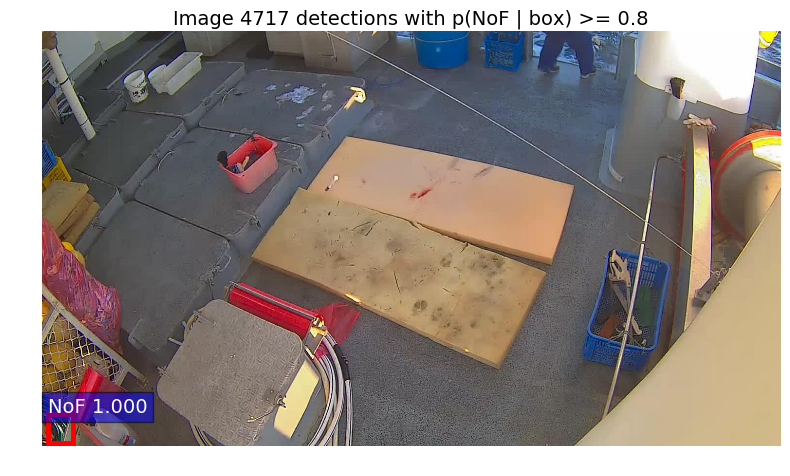

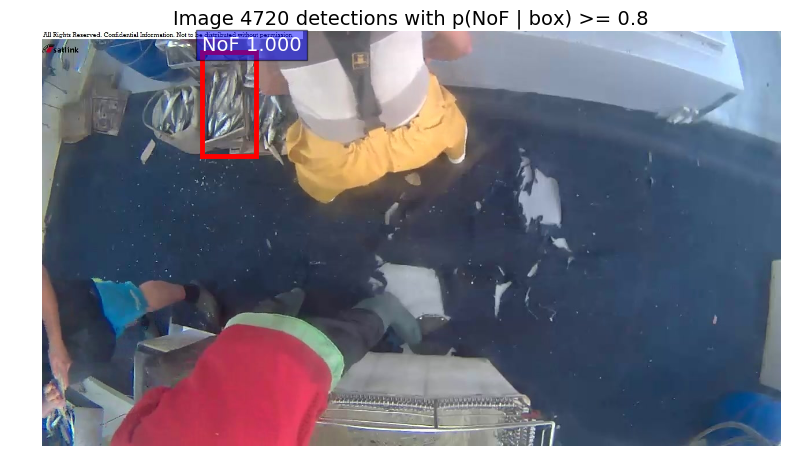

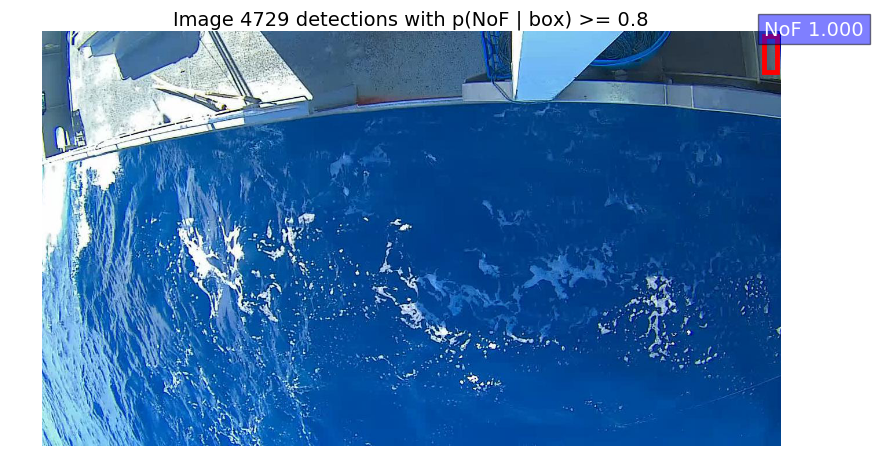

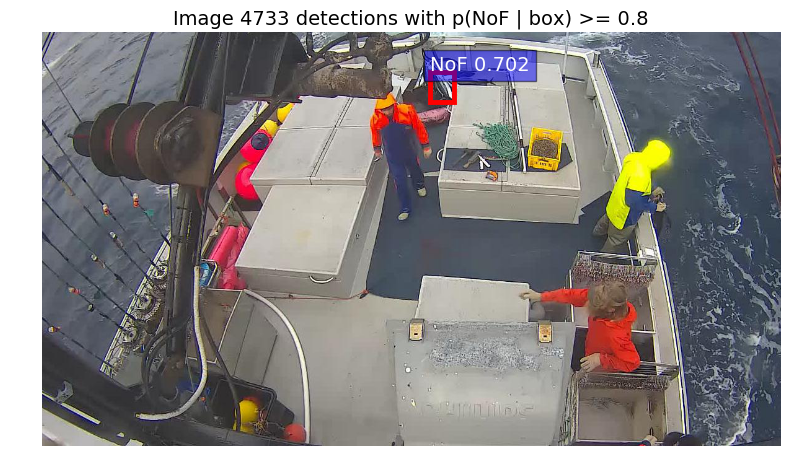

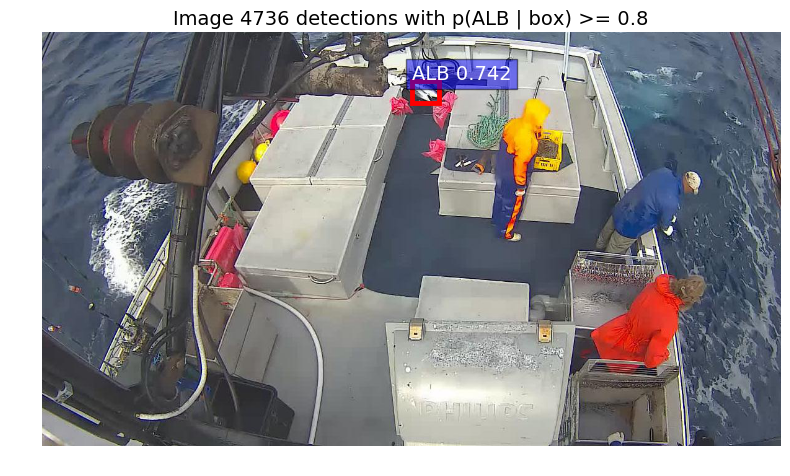

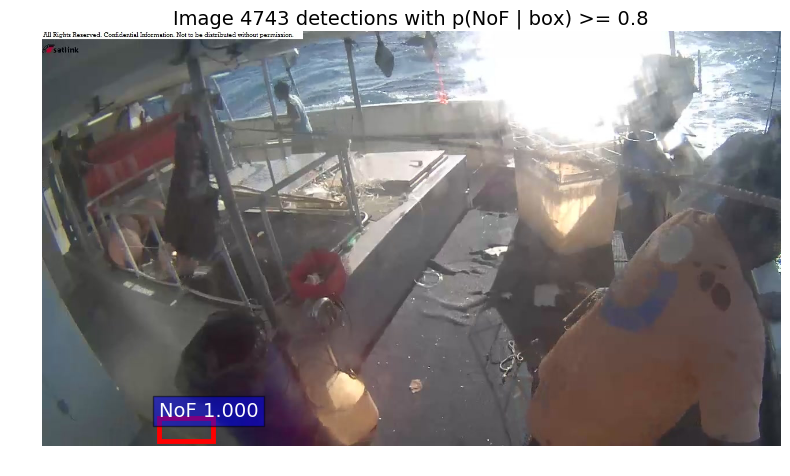

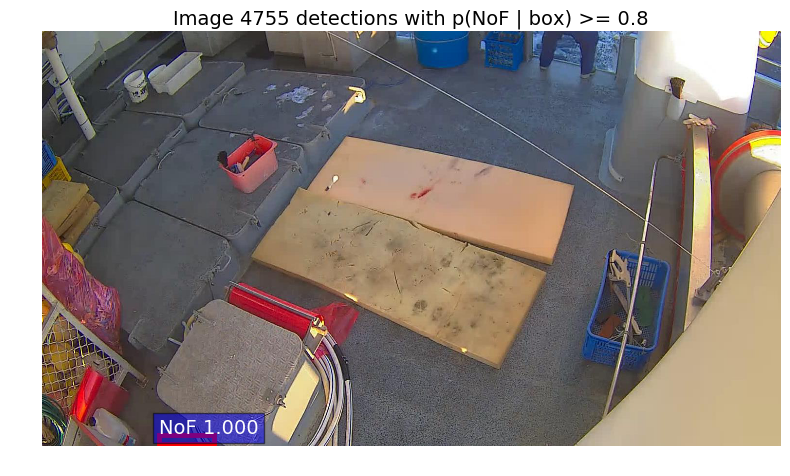

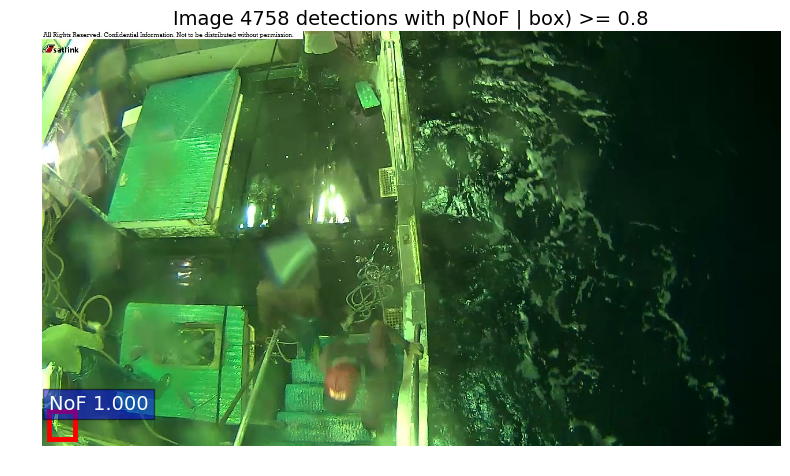

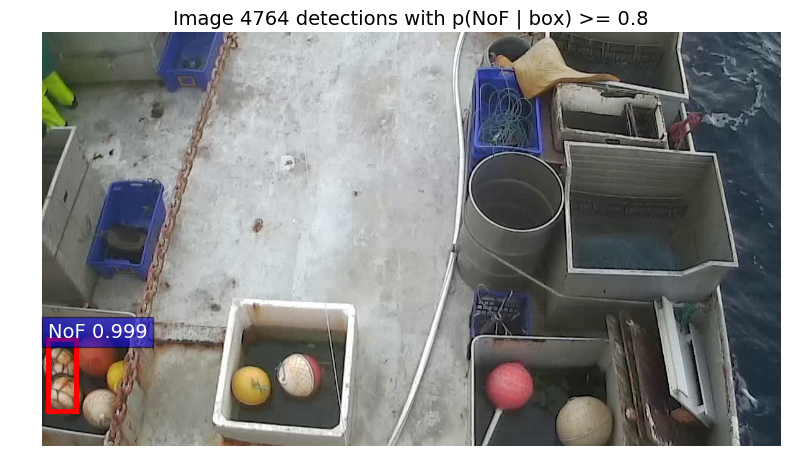

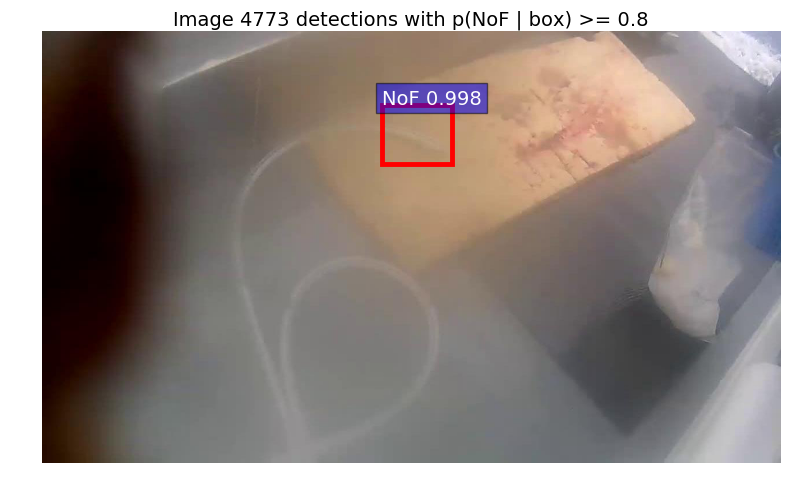

In [18]:
#visualize test image crop
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
test_files = [im[:-1]+'.jpg' for im in ims]

for j in np.ndarray.tolist(np.where(count==0)[0][-10:]):
    dets = outputs[j]
    print(dets)
    im = Image.open("../RFCN/JPEGImages/"+test_files[j])
    im = np.asarray(im)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.imshow(im, aspect='equal')
    for i in range(dets.shape[0]):
        bbox = dets[i, :4]
        score = np.amax(dets[i,4:])
        index = np.argmax(dets[i,4:])
        class_name = FISH_CLASSES[index]
        #if not (bbox[0] == 0 and bbox[1] == 0 and bbox[2] == 0 and bbox[3] == 0):
        ax.add_patch(plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5))
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('Image {} detections with '
                  'p({} | box) >= {:.1f}').format(j, class_name, CONF_THRESH),fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

In [ ]:
#submission from detections_full_AGNOSTICnms.pkl 取同类中score最高的，按类的数量加权平均

RFCN_MODEL = 'resnet101_rfcn_ohem_iter_30000'
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

import pickle 
with open('../data/RFCN_detections/detections_full_AGNOSTICnms_'+RFCN_MODEL+'.pkl','rb') as f:
    detections_full_AGNOSTICnms = pickle.load(f, encoding='latin1') 
    
CONF_THRESH = 0.9
outputs = np.ndarray((len(detections_full_AGNOSTICnms), len(FISH_CLASSES)), dtype=np.float64)

for im in range(len(detections_full_AGNOSTICnms)):
    if im%1000 == 0:
        print(im)
    detects_im = detections_full_AGNOSTICnms[im]
    score_max = np.max(detects_im[:,5:], axis=1)
    inds = np.argmax(detects_im[:,5:], axis=1)
    labels = [FISH_CLASSES[ind+1] for ind in inds]
    columns = ['box1', 'box2', 'box3', 'box4']
    columns.extend(FISH_CLASSES)
    detects_im_df = pd.DataFrame(detects_im, columns=columns)
    detects_im_df['max_cls'] = labels
    detects_im_df['max_score'] = score_max
    detects_im_df = detects_im_df[detects_im_df["max_score"]>=CONF_THRESH]  
    detects_im_df['Counts'] = detects_im_df.groupby(['max_cls'])['max_cls'].transform('count')
    idx = detects_im_df.groupby(['max_cls'])['max_score'].transform(max) == detects_im_df['max_score']
    detects_im_df = detects_im_df[idx]
    l = FISH_CLASSES.copy()
    l.append('Counts')
    detects_im_array = detects_im_df[l].as_matrix()
    if detects_im_array.shape[0] == 0:
        ind = np.argmax(score_max)
        outputs_im = detects_im[ind,4:12]
    else:
        outputs_im = np.average(detects_im_array[:,:-1], axis=0, weights=detects_im_array[:,-1], returned=False)
    outputs[im] = outputs_im
    


In [ ]:
# CLIP_THRESH = 0.02
# outputs_cliped = np.clip(outputs, CLIP_THRESH, 1, out=None)
# outputs_cliped = outputs_cliped/np.sum(outputs_cliped, axis=1, keepdims=True)
# test_preds = outputs_cliped[:1000]
# train_preds = outputs_cliped[1000:]

#temperature
T = 2.5
outputs_T = np.exp(np.log(outputs)/T)
outputs_T = outputs_T/np.sum(outputs_T, axis=1, keepdims=True)
test_preds = outputs_T[:1000]
train_preds = outputs_T[1000:]


with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
test_files = [im[:-1]+'.jpg' for im in ims[:1000]]
train_files = [im[:-1] for im in ims[1000:]]
with open("../RFCN/ImageSets/Main/train_test.txt","r") as f:
    train_file_labels = f.readlines()

log_losses = []
for i in range(len(train_preds)):
    im = train_files[i]
    for im_label in train_file_labels:
        if im == im_label[:9]:
            label = im_label[10:-1]
            index = FISH_CLASSES.index(label)
            log_losses.append(-math.log(train_preds[i][index]))
log_loss = sum(log_losses) / float(len(log_losses))
print('logloss of train is', log_loss )

import datetime

submission = pd.DataFrame(test_preds, columns=FISH_CLASSES)
#submission.loc[:, 'image'] = pd.Series(test_files, index=submission.index)
submission.insert(0, 'image', test_files)

now = datetime.datetime.now()
# info = 'RFCN_AGONOSTICnms_clsMaxAve_resnet101_rfcn_ohem_iter_30000_conf{:.1f}_'.format(CONF_THRESH) + 'clip{:.2f}_'.format(CLIP_THRESH) + '{:.4f}'.format(log_loss)
info = 'RFCN_AGONOSTICnms_clsMaxAve_'+RFCN_MODEL+'_conf{:.2f}_T{}_'.format(CONF_THRESH, T) + '{:.4f}'.format(log_loss)
sub_file = 'submission_' + info + '.csv'
submission.to_csv(sub_file, index=False)